In [1]:
import gbtoolbox.bounds as bounds
import gbtoolbox.misc as mt
import gbtoolbox.dft as dft
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
print(torch.__version__)
from datetime import datetime
from torch.utils.data import Dataset, DataLoader, TensorDataset


/home/jonathan/miniconda/envs/torch_summer23/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jonathan/miniconda/envs/torch_summer23/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/jonathan/miniconda/envs/torch_summer23/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jonathan/miniconda/envs/torch_summer23/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


2.1.0.dev20230711


In [2]:
N = 80
mult = 80*1
span = 2
x = (np.random.rand(mult*N).reshape(-1,2)*2-1)*span/2.0

In [3]:
print(x)

[[ 0.41072704  0.23342466]
 [-0.45247227  0.55660286]
 [-0.71328145  0.17428748]
 ...
 [-0.00472924  0.04880183]
 [-0.41249183  0.99328631]
 [-0.74909343  0.97427701]]


Note that in the theory, and in the toolbox, the input space is $[-1,1]^d$. So if your space is $[0,2\pi]^d$ for example, the input needs scaled properly.

In [4]:
y = np.sin(2.1*1*np.pi*x[:,0])*np.sin(3.4*1*np.pi*x[:,1])

In [5]:
print(y)

[ 0.25274976  0.05165872  0.95798213 ... -0.01553479  0.37798289
 -0.80971356]


In [6]:
f, _ = mt.gen_stacked_equispaced_nd_grid(N,np.array([[-Bt/2.0,Bt/2.0] for Bt in np.array([N/span,N/span])]))
V = span*span
spans = np.tile([-span/2.0,span/2.0],(2,1))
print(f.shape)

(6400, 2)


(6400, 1)


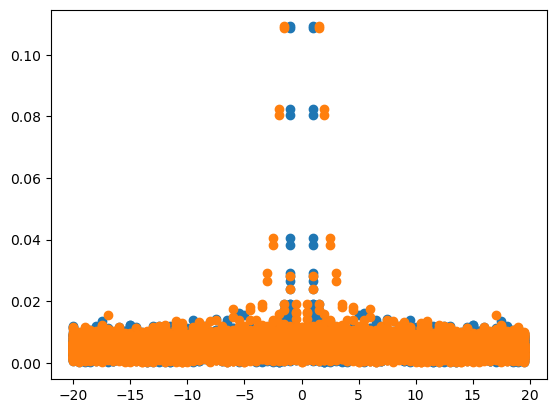

In [7]:
yf = (V/x.shape[0])*dft.nu_dft_cuda(x,y,f,256,128)/(np.sqrt(2*np.pi)**2)
print(yf.shape)
plt.scatter(f[:,0],np.abs(yf))
plt.scatter(f[:,1],np.abs(yf))

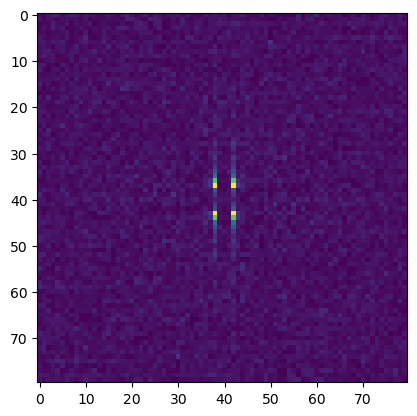

In [8]:
plt.imshow(np.abs(yf).reshape(N,N))

This gives an initial look, we see some noise induced sampling that is down at 0.018 or maybe even 0.024. We also see some extended tales going up/down. I would recommend looking at several plots when making cuts, in this one ther eis no internal peaks.

In [9]:
f, _ = mt.gen_stacked_equispaced_nd_grid(N,np.array([[-Bt/4.0,Bt/4.0] for Bt in np.array([N/span,N/span])]))
V = span*span
spans = np.tile([-span/2.0,span/2.0],(2,1))
print(f.shape)

(6400, 2)


(6400, 1)


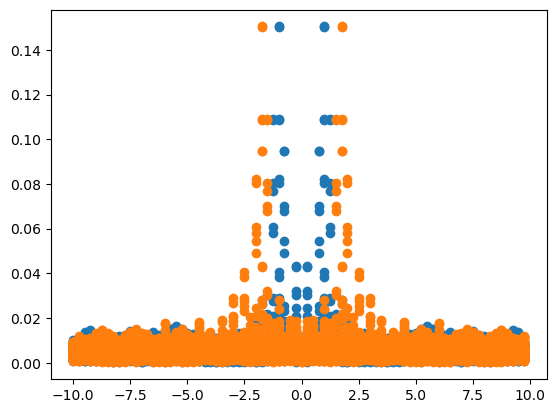

In [10]:
yf = (V/x.shape[0])*dft.nu_dft_cuda(x,y,f,256,128)/(np.sqrt(2*np.pi)**2)
print(yf.shape)
plt.scatter(f[:,0],np.abs(yf))
plt.scatter(f[:,1],np.abs(yf))

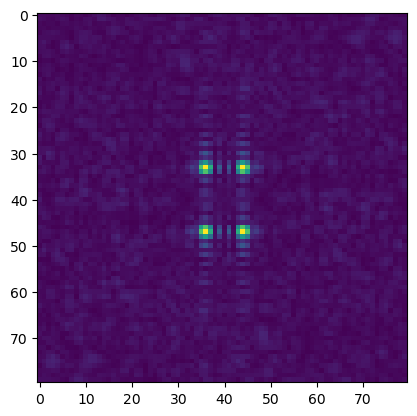

In [11]:
plt.imshow(np.abs(yf).reshape(N,N))


Here instead of an extended line, we see some side lobes, which is suggestive. We also see a lot of gap in the center, but not on one axis. This should have been seen in the previous plot if it was real. So already we are inclined to cut above maybe 0.06.

In [12]:
f, _ = mt.gen_stacked_equispaced_nd_grid(N,np.array([[-Bt,Bt] for Bt in np.array([N/span,N/span])]))
V = span*span
spans = np.tile([-span/2.0,span/2.0],(2,1))
print(f.shape)

(6400, 2)


(6400, 1)


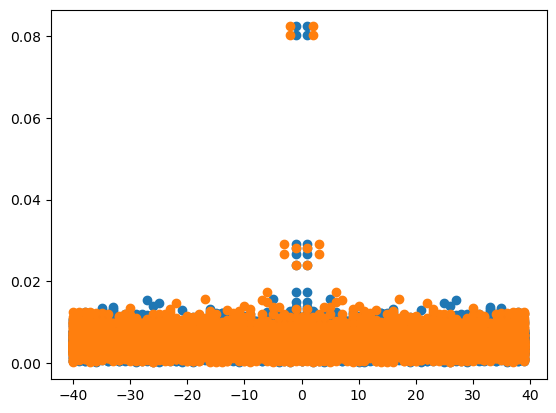

In [13]:
yf = (V/x.shape[0])*dft.nu_dft_cuda(x,y,f,256,128)/(np.sqrt(2*np.pi)**2)
print(yf.shape)
plt.scatter(f[:,0],np.abs(yf))
plt.scatter(f[:,1],np.abs(yf))

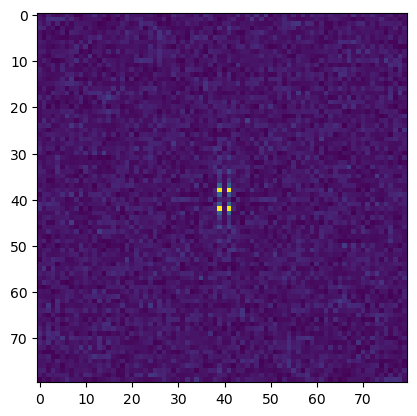

In [14]:
plt.imshow(np.abs(yf).reshape(N,N))

It looks like there is a narrow peak around 0.4 and 0.5. Remember that $w=2\pi f$. Note that we can see two factors here, one with the extension (side lobes in other resolutions) and the other is the random sampling error induced by the low number of samples.

In [15]:
print(N/span)

40.0


In [16]:
f, _ = mt.gen_stacked_equispaced_nd_grid(N*2,np.array([[-Bt,Bt] for Bt in np.array([4,4])]))
V = span*span
spans = np.tile([-1,1],(2,1))
print(f.shape)

(25600, 2)


(25600, 1)


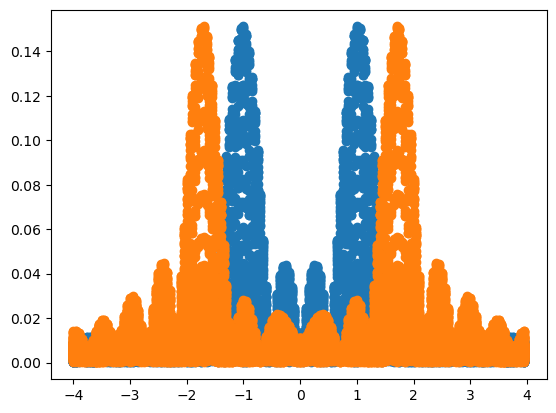

In [17]:
yf = (V/x.shape[0])*dft.nu_dft_cuda(x,y,f,256,128)/(np.sqrt(2*np.pi)**2)
print(yf.shape)
plt.scatter(f[:,0],np.abs(yf))
plt.scatter(f[:,1],np.abs(yf))

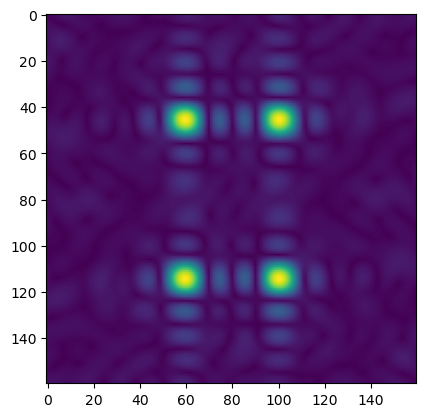

In [18]:
plt.imshow(np.abs(yf).reshape(N*2,N*2))

Text(0, 0.5, 'k')

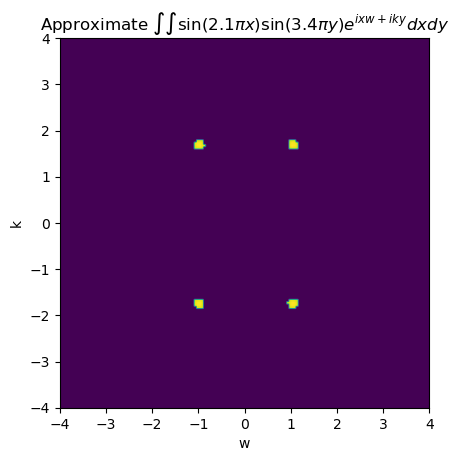

In [111]:
mask = dft.threshold_cmask(yf,0.140)
plt.imshow(np.abs(yf*mask.astype(int)).reshape(N*2,N*2),extent=[-4,4,-4,4])
plt.title('Approximate $\int\int\sin(2.1\pi x)\sin(3.4\pi y)e^{i x w + i k y} dx dy$')
plt.xlabel('w')
plt.ylabel('k')

In these plots we cut for just the 4 peaks. We can clearly cut the other peaks because we see them move as we adjust the resolution in $f$. How tightly to cut the 4 peaks is something that might not be known in general, although we can try periodization to see how wide the real peak is. Here I am making a tight cut.

In [20]:
sne = bounds.est_spec_norm(f*2*np.pi,yf,None,mask)
print(sne)

1638.2182101216138


This is much larger than the analytic calculation of approximately 470, but this is to be expected due the nature of the problem and the nature of the non-equispaced to equispaced FT.

In [21]:
abnd = bounds.apriori_bound(sne,15000,N*mult/2,2,0.95)
print(abnd)

1308.4097312866545


The bound is high, but then the Barron norm/Spectral norm is high.

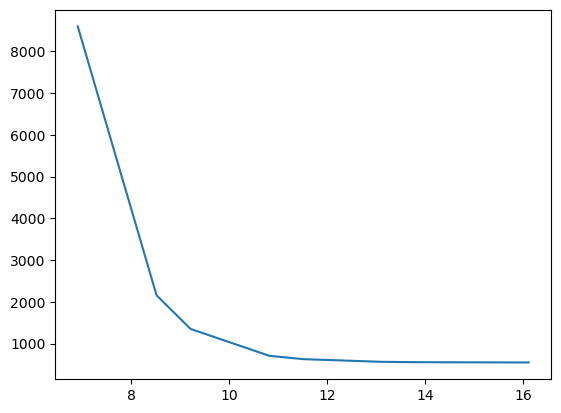

In [22]:
plt.plot(np.log(np.array([1e3,5e3,1e4,5e4,1e5,5e5,1e6,1e7])),[bounds.apriori_bound(sne,MM,N*mult,2,0.95) for MM in np.array([1e3,5e3,1e4,5e4,1e5,5e5,1e6,1e7])])

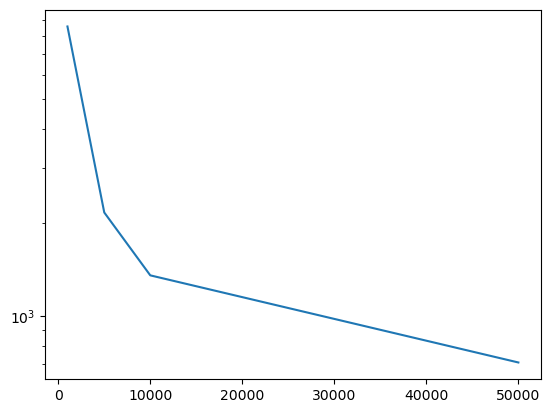

In [133]:
plt.plot(np.array([1e3,5e3,1e4,5e4]),[bounds.apriori_bound(sne,MM,N*mult,2,0.95) for MM in np.array([1e3,5e3,1e4,5e4])])
plt.yscale('log')

We see the expected limiting behavior as a function of number of nodes. Do we see the right behavior if we keep the Spectral norm constant?

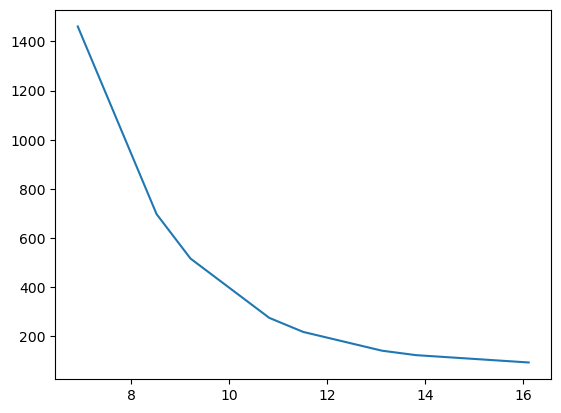

In [23]:
plt.plot(np.log(np.array([1e3,5e3,1e4,5e4,1e5,5e5,1e6,1e7])),[bounds.apriori_bound(sne,1e5,NN,2,0.95) for NN in np.array([1e3,5e3,1e4,5e4,1e5,5e5,1e6,1e7])])

Now while the Spectral norm/Barron norm is large, we can still use this as part of our initialization.

In [24]:
masks = np.hstack((mask,mask))

In [25]:
pdf=bounds.E_pdf((mask.astype(int)*yf),2*np.pi*((masks.astype(int)*f).T))

In [26]:
MM=45000
zv, tv, wv, sv = pdf.gen_ztw(MM)
wh, wn = bounds.nn_wnorm(wv)
print(wh.shape)

(2, 45000)


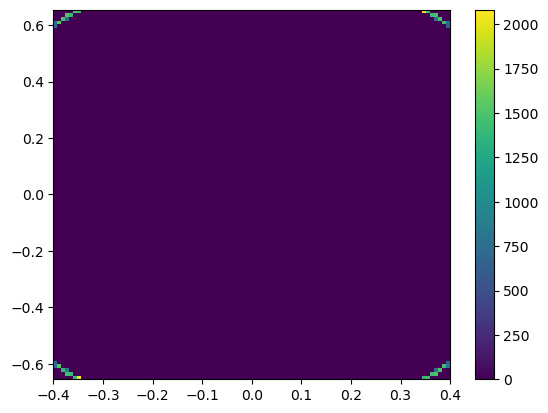

In [27]:
h2d,x2d,y2d,i2d=plt.hist2d(wh.T[:,0],wh.T[:,1],bins=100)
plt.colorbar()

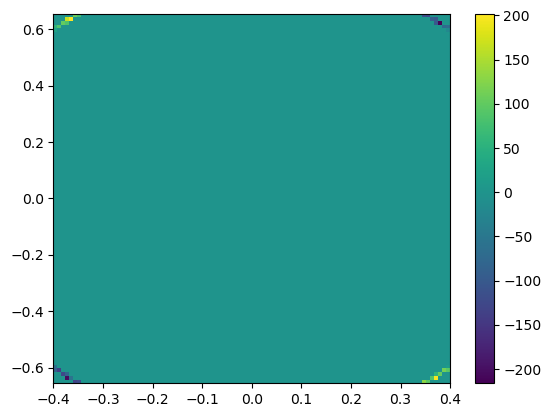

In [28]:
h2d,x2d,y2d,i2d=plt.hist2d(wh.T[:,0],wh.T[:,1],bins=100,weights=sv)
plt.colorbar()

In [29]:
print(np.sum(h2d[:40,:40]))
print(np.sum(h2d[:40,60:]))
print(np.sum(h2d[60:,:40]))
print(np.sum(h2d[60:,60:]))

-1001.0
916.0
883.0
-902.0


Here we know the answer, so we know that each 'peak' should be equal in magnitude but two negative and two positive. We see a smallish assymetry here, and it is this assymetry, from the outer weight sign, that drives the linear gradient that can be very strong in the approximation. The sign will be more accurate the more accurate the approximate FT is. 

(array([22552.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 22448.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

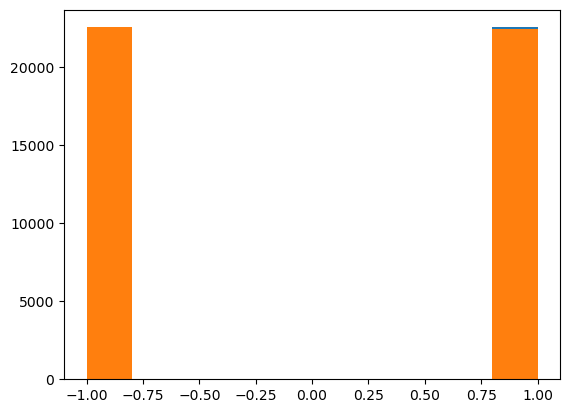

In [30]:
plt.hist(zv)
plt.hist(sv)

We don't see an overall assymetry, which is good, but just terms being off can be bad. One possible solution is to provide both -1 and 1 to the network, with some small 'noise' difference in magnitude, and then let training the neural network move the wrong sign to 0. We don't expect the argument to be as well determined as the magnitude.

(array([254., 356., 530., 606., 647., 582., 500., 359., 261., 216., 352.,
        481., 615., 657., 641., 497., 371., 197., 183., 286., 487., 662.,
        677., 640., 500., 374., 187., 139., 318., 503., 628., 710., 702.,
        561., 442., 207., 106., 266., 483., 607., 641., 706., 601., 424.,
        209.,  63., 254., 461., 591., 711., 672., 645., 431., 264.,  71.,
        222., 468., 593., 726., 678., 615., 505., 260.,  92., 208., 422.,
        597., 687., 696., 589., 481., 307., 147., 206., 386., 578., 649.,
        708., 602., 474., 367., 179., 202., 353., 532., 584., 628., 622.,
        475., 333., 218., 222., 362., 502., 585., 635., 630., 479., 370.,
        292.]),
 array([-9.99917098e-01, -9.79918151e-01, -9.59919204e-01, -9.39920257e-01,
        -9.19921310e-01, -8.99922363e-01, -8.79923416e-01, -8.59924469e-01,
        -8.39925522e-01, -8.19926575e-01, -7.99927628e-01, -7.79928681e-01,
        -7.59929733e-01, -7.39930786e-01, -7.19931839e-01, -6.99932892e-01,
        -6.799

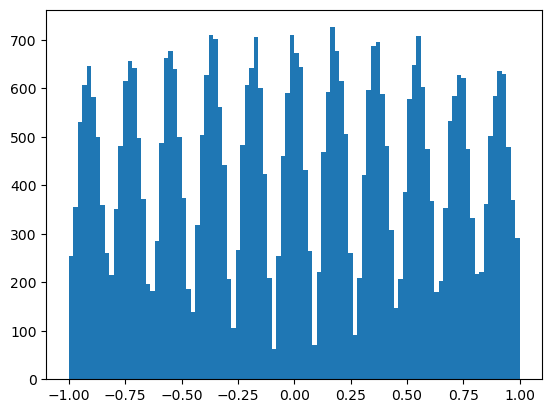

In [31]:
plt.hist(tv*zv,bins=100)

This  behaves well here.

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
tensor_x = torch.Tensor(x) # transform to torch tensor
tensor_y = torch.Tensor(y)

In [34]:
print(torch.backends.cudnn.is_available())

True


In [44]:

class ShallowRegressor(nn.Module):
    def __init__(self):
        super(ShallowRegressor,self).__init__()
        self.fc1 = nn.Linear(2,MM)
        self.fc2 = nn.Linear(MM,1)     
        self.fc1.weight = torch.nn.Parameter(torch.Tensor(wh.T))
        self.fc1.bias = torch.nn.Parameter(torch.Tensor(tv*zv))      
        self.fc2.bias = torch.nn.Parameter(torch.Tensor(np.array([np.mean(y)])))
        self.fc2.weight = torch.nn.Parameter(torch.Tensor((sne)*(sv).reshape(-1,1).T/MM))
      
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [45]:
model = ShallowRegressor()

In [46]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

In [47]:
loss_fn = torch.nn.MSELoss()

In [48]:
model = model.to(device)

In [66]:
print(tensor_x)
print(tensor_x.shape)
ABS = 60
XX = np.linspace(-1,1,ABS,endpoint=False)
XXg = mt.grid_to_stack(np.meshgrid(XX,XX))
print(XXg)
print(XXg.shape)
print(torch.Tensor(XXg))

tensor([[ 0.4107,  0.2334],
        [-0.4525,  0.5566],
        [-0.7133,  0.1743],
        ...,
        [-0.0047,  0.0488],
        [-0.4125,  0.9933],
        [-0.7491,  0.9743]])
torch.Size([3200, 2])
[[-1.         -1.        ]
 [-0.96666667 -1.        ]
 [-0.93333333 -1.        ]
 ...
 [ 0.9         0.96666667]
 [ 0.93333333  0.96666667]
 [ 0.96666667  0.96666667]]
(3600, 2)
tensor([[-1.0000, -1.0000],
        [-0.9667, -1.0000],
        [-0.9333, -1.0000],
        ...,
        [ 0.9000,  0.9667],
        [ 0.9333,  0.9667],
        [ 0.9667,  0.9667]])


In [67]:
model.eval()
YYg = model(torch.Tensor(XXg).to(device))

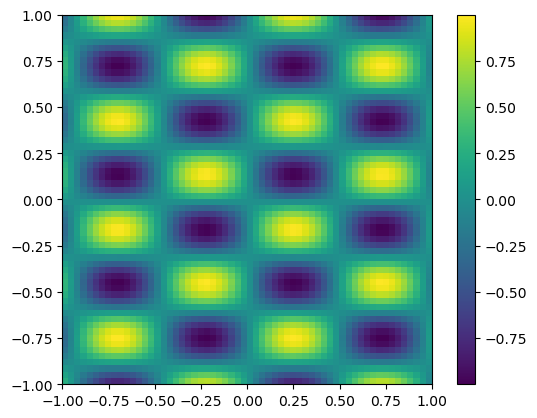

In [72]:
plt.imshow((np.sin(2.1*1*np.pi*XXg[:,0])*np.sin(3.4*1*np.pi*XXg[:,1])).reshape(ABS,ABS),extent=[-1, 1, -1, 1])
plt.colorbar()

We see a nice simple pattern.

torch.Size([3600, 1])
tensor([[-2.0497],
        [-1.2385],
        [-0.4498],
        ...,
        [-0.4337],
        [-1.0869],
        [-1.7704]], device='cuda:0', grad_fn=<AddmmBackward0>)


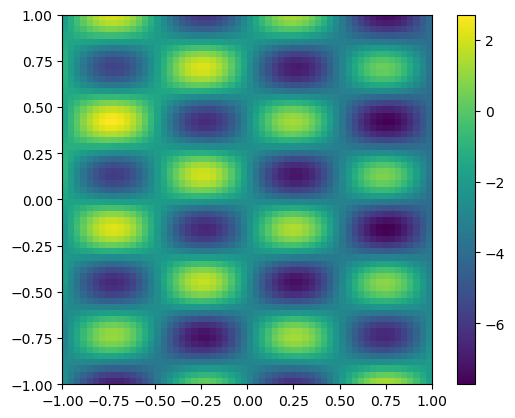

In [75]:
print(YYg.shape)
print(YYg)
plt.imshow(YYg.detach().cpu().numpy().reshape(ABS,ABS),extent=[-1,1, -1, 1])
plt.colorbar()

We see the same patern, but probably with a different scale (maybe even 10x too high) and with some roughly linear gradient. This is most likely because of our lower approximate Fourier transform. If the 4 peaks are a bit unbalanced due to the number of samples, we will get a gradient. If we have a too large Spectral norm, we will be too high. If we don't cut agressively enough and include a lot more of the region around the peak, we will have a gradient. This all requires some work. In general we want to do as good of job as we can, and then possibly do additional corrections with training.

In [70]:
print(x.shape)

(3200, 2)


torch.Size([3600, 1])
tensor([[-2.0497],
        [-1.2385],
        [-0.4498],
        ...,
        [-0.4337],
        [-1.0869],
        [-1.7704]], device='cuda:0', grad_fn=<AddmmBackward0>)
10.432267
1.998574704120086
1.5186532530416965


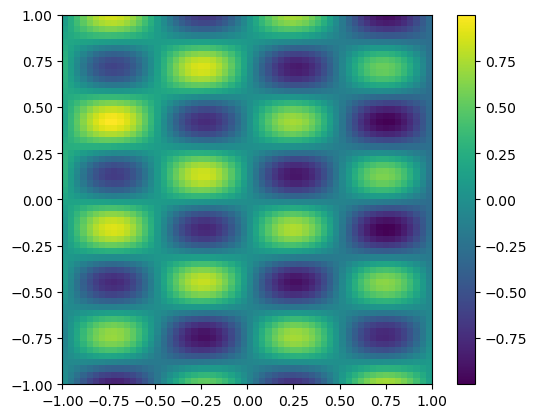

In [76]:
print(YYg.shape)
print(YYg)
maxYY=np.max(YYg.detach().cpu().numpy())
maxXX=np.max((np.sin(2.1*1*np.pi*XXg[:,0])*np.sin(3.4*1*np.pi*XXg[:,1])))
factorYY=np.max(YYg.detach().cpu().numpy())-np.min(YYg.detach().cpu().numpy())
factorXX=np.max((np.sin(2.1*1*np.pi*XXg[:,0])*np.sin(3.4*1*np.pi*XXg[:,1])))-np.min((np.sin(2.1*1*np.pi*XXg[:,0])*np.sin(3.4*1*np.pi*XXg[:,1])))
print(factorYY)
print(factorXX)
print(maxYY/factorYY*factorXX+maxXX)
plt.imshow(YYg.detach().cpu().numpy().reshape(ABS,ABS)/factorYY*factorXX-maxYY/factorYY*factorXX+maxXX,extent=[-1,1, -1, 1])
plt.colorbar()

In [91]:
xt = (np.random.rand(mult*N).reshape(-1,2)*2-1)*span/2.0
yt = np.sin(2.1*1*np.pi*xt[:,0])*np.sin(3.4*1*np.pi*xt[:,1])

Text(0, 0.5, 'y')

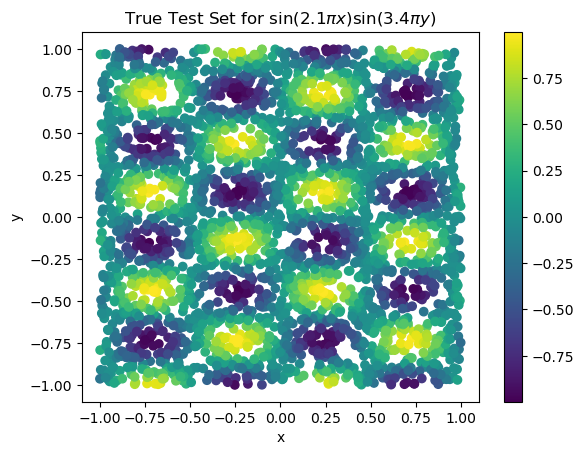

In [106]:
plt.scatter(xt[:,0], xt[:,1], c=(np.sin(2.1*1*np.pi*xt[:,0])*np.sin(3.4*1*np.pi*xt[:,1])))
plt.colorbar()
plt.title('True Test Set for $\sin(2.1\pi x)\sin(3.4\pi y)$')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

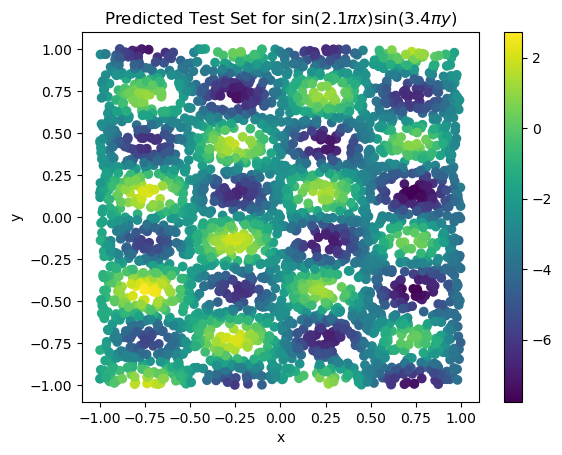

In [107]:
plt.scatter(xt[:,0], xt[:,1], c=model(torch.Tensor(xt).to(device)).detach().cpu().numpy())
plt.colorbar()
plt.title('Predicted Test Set for $\sin(2.1\pi x)\sin(3.4\pi y)$')
plt.xlabel('x')
plt.ylabel('y')

[[-0.5074233 ]
 [ 0.5117292 ]
 [ 0.29035258]
 ...
 [-0.02596545]
 [-0.03453815]
 [-0.09999013]]
(3200, 1)
(3200,)


Text(0, 0.5, 'y')

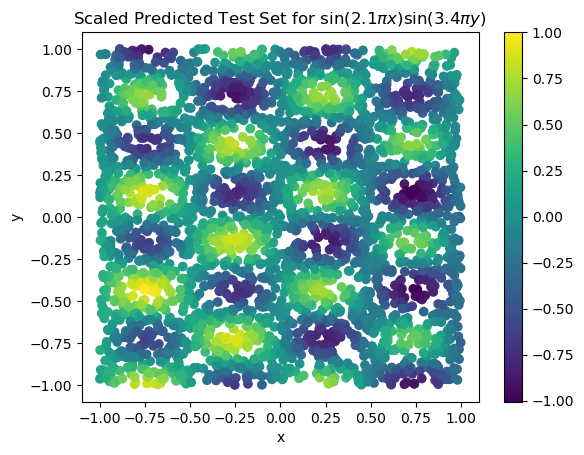

In [108]:
diff = model(torch.Tensor(xt).to(device)).detach().cpu().numpy()/factorYY*factorXX-maxYY/factorYY*factorXX+maxXX
print(diff)
print(diff.shape)
print((np.sin(2.1*1*np.pi*xt[:,0])*np.sin(3.4*1*np.pi*xt[:,1])).shape)
#diff=diff-(np.sin(2.1*1*np.pi*xt[:,0])*np.sin(3.4*1*np.pi*xt[:,1])).reshape(-1,1)
plt.scatter(xt[:,0], xt[:,1], c=diff)
plt.colorbar()
plt.title('Scaled Predicted Test Set for $\sin(2.1\pi x)\sin(3.4\pi y)$')
plt.xlabel('x')
plt.ylabel('y')

In [100]:
from sklearn.metrics import mean_squared_error

In [101]:
mean_squared_error((np.sin(2.1*1*np.pi*xt[:,0])*np.sin(3.4*1*np.pi*xt[:,1])).reshape(-1,1), model(torch.Tensor(xt).to(device)).detach().cpu().numpy()/factorYY*factorXX-maxYY/factorYY*factorXX+maxXX)

0.028717124064530992

Text(0, 0.5, 'y')

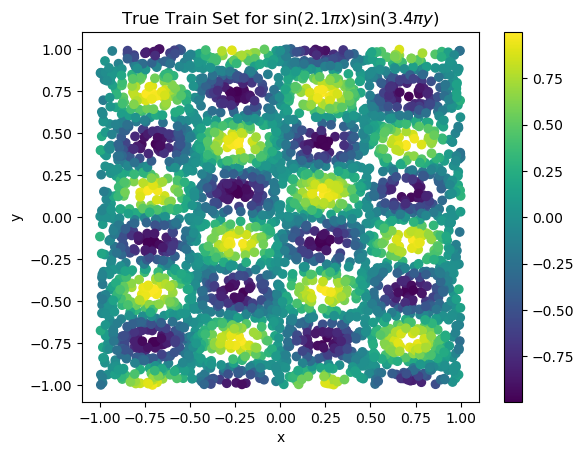

In [112]:
plt.scatter(x[:,0], x[:,1], c=y)
plt.colorbar()
plt.title('True Train Set for $\sin(2.1\pi x)\sin(3.4\pi y)$')
plt.xlabel('x')
plt.ylabel('y')

In [120]:
class ShallowRegressor2(nn.Module):
    def __init__(self):
        super(ShallowRegressor2,self).__init__()
        self.fc1 = nn.Linear(2,MM)
        self.fc2 = nn.Linear(MM,1)     
        #self.fc1.weight = torch.nn.Parameter(torch.Tensor(wh.T))
        #self.fc1.bias = torch.nn.Parameter(torch.Tensor(tv*zv))      
        #self.fc2.bias = torch.nn.Parameter(torch.Tensor(np.array([np.mean(y)])))
        #self.fc2.weight = torch.nn.Parameter(torch.Tensor((sne)*(sv).reshape(-1,1).T/MM))
      
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [121]:
model2 = ShallowRegressor2()
model2 = model2.to(device)
model2.eval()

ShallowRegressor2(
  (fc1): Linear(in_features=2, out_features=45000, bias=True)
  (fc2): Linear(in_features=45000, out_features=1, bias=True)
)

Text(0, 0.5, 'y')

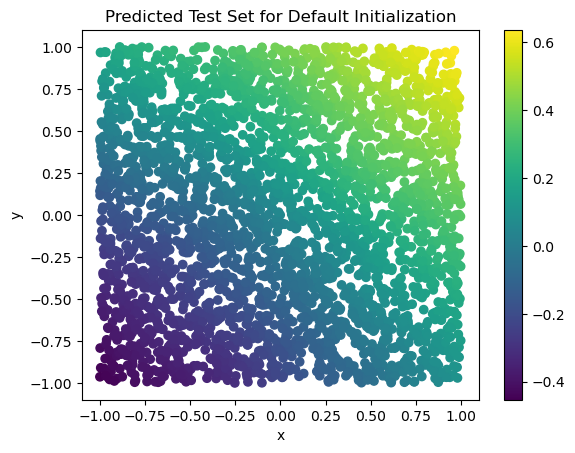

In [123]:
plt.scatter(xt[:,0], xt[:,1], c=model2(torch.Tensor(xt).to(device)).detach().cpu().numpy())
plt.colorbar()
plt.title('Predicted Test Set for Default Initialization')
plt.xlabel('x')
plt.ylabel('y')

In [125]:
print(pdf.magw_f)

[17.90707813 17.59291886 17.27875959 17.27875959 17.59291886 17.90707813
 17.90707813 17.59291886 17.27875959 16.96460033 16.96460033 17.27875959
 17.59291886 17.90707813 17.59291886 17.27875959 16.96460033 16.65044106
 16.3362818  16.65044106 16.96460033 17.27875959 17.59291886 17.27875959
 16.96460033 16.65044106 16.3362818  16.3362818  16.65044106 16.96460033
 17.27875959 17.27875959 16.96460033 16.65044106 16.3362818  16.3362818
 16.65044106 16.96460033 17.27875959 17.59291886 17.27875959 16.96460033
 16.65044106 16.3362818  16.65044106 16.96460033 17.27875959 17.59291886
 17.90707813 17.59291886 17.27875959 16.96460033 16.96460033 17.27875959
 17.59291886 17.90707813 17.90707813 17.59291886 17.27875959 17.27875959
 17.59291886 17.90707813]
